*   This is to support part V.B.ii in our paper
*   We factor sentiment element into Tweets and then visualize the relationship between Amazon stock price and Tweets

In [ ]:
%matplotlib inline 

import datetime
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
import statsmodels.api as sm
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

# special matplotlib argument for improved plots
from matplotlib import rcParams
rcParams['figure.figsize'] = 12, 6

In [ ]:
#Use dataframe that we exported from coding file "V_A_Tweet_Sentiment_Analysis" and stock price data from Kaggle
Tesla = pd.read_csv('Tesla.csv')
company_value = pd.read_csv('CompanyValues.csv')
company_value.head()

,ticker_symbol,day_date,close_value,volume,open_value,high_value,low_value
0,AAPL,2020-05-29,317.94,38399530,319.25,321.15,316.47
1,AAPL,2020-05-28,318.25,33449100,316.77,323.44,315.63
2,AAPL,2020-05-27,318.11,28236270,316.14,318.71,313.09
3,AAPL,2020-05-26,316.73,31380450,323.50,324.24,316.50
4,AAPL,2020-05-22,318.89,20450750,315.77,319.23,315.35


In [ ]:
#Add column of daily returns into the stock price table
company_value['returns'] = company_value.sort_values('day_date').groupby(['ticker_symbol']).close_value.pct_change()
Tesla_value = company_value[company_value['ticker_symbol'] == 'TSLA'].sort_values('day_date')
Tesla_value.head()

,ticker_symbol,day_date,close_value,volume,open_value,high_value,low_value,returns
16959,TSLA,2010-06-29,23.89,18751150,19.00,25.0000,17.54,NaN
16958,TSLA,2010-06-30,23.83,17165210,25.79,30.4192,23.30,-0.002512
16957,TSLA,2010-07-01,21.96,8216789,25.00,25.9200,20.27,-0.078473
16956,TSLA,2010-07-02,19.20,5135795,23.00,23.1000,18.71,-0.125683
16955,TSLA,2010-07-06,16.11,6858092,20.00,20.0000,15.83,-0.160937


In [ ]:
#Merge Tweets content and stock price dataframe
Tesla_tweet_vs_value =  pd.merge(Tesla, Tesla_value, left_on=['post_date'], right_on = ['day_date'], how= "inner")
Tesla_tweet_vs_value['post_date'] = Tesla_tweet_vs_value['post_date'].apply(lambda date: pd.to_datetime(date))
Tesla_tweet_vs_value.head()

,tweet_id,ticker_symbol_x,writer,post_date,body,comment_num,retweet_num,like_num,total_engangement,sentiment_scores,score,ticker_symbol_y,day_date,close_value,volume,open_value,high_value,low_value,returns
0,550793298357391360,TSLA,ScoutingGW,2015-01-01,"#bluechips like $TSLA, $AAPL, $DIS, $TWTR & NV...",0,0,3,3,"{'neg': 0.0, 'neu': 0.752, 'pos': 0.248, 'comp...",Positive,TSLA,2015-01-01,222.41,2392947,223.09,225.68,222.25,0.0
1,550780769497808896,TSLA,SharePlanner,2015-01-01,2014 Was A Great Year of Trading In The Splash...,1,0,1,3,"{'neg': 0.0, 'neu': 0.82, 'pos': 0.18, 'compou...",Positive,TSLA,2015-01-01,222.41,2392947,223.09,225.68,222.25,0.0
2,550703624544718848,TSLA,laurenholmesNYC,2015-01-01,Best Trade: $AAPL; $GOOG $TSLA $YHOO $LNKD I r...,0,1,2,5,"{'neg': 0.0, 'neu': 0.724, 'pos': 0.276, 'comp...",Positive,TSLA,2015-01-01,222.41,2392947,223.09,225.68,222.25,0.0
3,550676585393569792,TSLA,laurenholmesNYC,2015-01-01,$AAPL $ARWR $TSLA $BABA Wish everyone happy ne...,0,1,1,4,"{'neg': 0.0, 'neu': 0.729, 'pos': 0.271, 'comp...",Positive,TSLA,2015-01-01,222.41,2392947,223.09,225.68,222.25,0.0
4,550673738161610752,TSLA,laurenholmesNYC,2015-01-01,$AAPL $TSLA $GILD $CELG $BABA $SCTY $RIG $WFM ...,0,1,1,4,"{'neg': 0.087, 'neu': 0.74, 'pos': 0.173, 'com...",Positive,TSLA,2015-01-01,222.41,2392947,223.09,225.68,222.25,0.0


In [ ]:
#Allocate the numeric score into n_score attribute for each sentiment status: Positive = 1; Neutral = 0.5; Negative = -1
n_score = []
for i in range(len(Tesla_tweet_vs_value['score'])):
    if Tesla_tweet_vs_value['score'][i] == 'Positive':
        n_score.append(1)
    elif Tesla_tweet_vs_value['score'][i] == 'Neutral':
        n_score.append(0.5)
    elif Tesla_tweet_vs_value['score'][i] == 'Negative':
        n_score.append(-1)
Tesla_tweet_vs_value['n_score'] = n_score
Tesla_tweet_vs_value.head(100)

#Calculate the total score of each Tweet
total_score = []
for i in range(len(Tesla_tweet_vs_value['total_engangement'])):
    total_score.append(Tesla_tweet_vs_value['total_engangement'][i]*Tesla_tweet_vs_value['n_score'][i])

Tesla_tweet_vs_value['total_score'] = total_score
Tesla_tweet_vs_value.head()

,tweet_id,ticker_symbol_x,writer,post_date,body,comment_num,retweet_num,like_num,total_engangement,sentiment_scores,...,ticker_symbol_y,day_date,close_value,volume,open_value,high_value,low_value,returns,n_score,total_score
0,550793298357391360,TSLA,ScoutingGW,2015-01-01,"#bluechips like $TSLA, $AAPL, $DIS, $TWTR & NV...",0,0,3,3,"{'neg': 0.0, 'neu': 0.752, 'pos': 0.248, 'comp...",...,TSLA,2015-01-01,222.41,2392947,223.09,225.68,222.25,0.0,1.0,3.0
1,550780769497808896,TSLA,SharePlanner,2015-01-01,2014 Was A Great Year of Trading In The Splash...,1,0,1,3,"{'neg': 0.0, 'neu': 0.82, 'pos': 0.18, 'compou...",...,TSLA,2015-01-01,222.41,2392947,223.09,225.68,222.25,0.0,1.0,3.0
2,550703624544718848,TSLA,laurenholmesNYC,2015-01-01,Best Trade: $AAPL; $GOOG $TSLA $YHOO $LNKD I r...,0,1,2,5,"{'neg': 0.0, 'neu': 0.724, 'pos': 0.276, 'comp...",...,TSLA,2015-01-01,222.41,2392947,223.09,225.68,222.25,0.0,1.0,5.0
3,550676585393569792,TSLA,laurenholmesNYC,2015-01-01,$AAPL $ARWR $TSLA $BABA Wish everyone happy ne...,0,1,1,4,"{'neg': 0.0, 'neu': 0.729, 'pos': 0.271, 'comp...",...,TSLA,2015-01-01,222.41,2392947,223.09,225.68,222.25,0.0,1.0,4.0
4,550673738161610752,TSLA,laurenholmesNYC,2015-01-01,$AAPL $TSLA $GILD $CELG $BABA $SCTY $RIG $WFM ...,0,1,1,4,"{'neg': 0.087, 'neu': 0.74, 'pos': 0.173, 'com...",...,TSLA,2015-01-01,222.41,2392947,223.09,225.68,222.25,0.0,1.0,4.0


In [ ]:
#Extract data that we want to visualize
Tesla_visual = Tesla_tweet_vs_value[['post_date','score','total_score','returns', 'close_value']]
Tesla_visual.head()

,post_date,score,total_score,returns,close_value
0,2015-01-01,Positive,3.0,0.0,222.41
1,2015-01-01,Positive,3.0,0.0,222.41
2,2015-01-01,Positive,5.0,0.0,222.41
3,2015-01-01,Positive,4.0,0.0,222.41
4,2015-01-01,Positive,4.0,0.0,222.41


In [ ]:
#Group the data by post_date
Tesla_visual_group = Tesla_visual.groupby(['post_date'])['close_value','returns','total_score'].mean()
Tesla_visual_group

<ipython-input-8-952dba9394c8>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  Tesla_visual_group = Tesla_visual.groupby(['post_date'])['close_value','returns','total_score'].mean()


,close_value,returns,total_score
post_date,,,
2015-01-01,222.41,0.000000,1.186869
2015-01-02,219.31,-0.013938,0.828358
2015-01-03,219.31,0.000000,1.109375
2015-01-04,219.31,0.000000,0.907895
2015-01-05,210.09,-0.042041,0.766187
...,...,...,...
2019-12-27,430.38,-0.001299,5.356322
2019-12-28,430.38,0.000000,7.044000
2019-12-29,430.38,0.000000,4.601896


In [ ]:
Tesla_posneg = Tesla_visual.groupby(['post_date'])['close_value','returns','total_score'].mean('total_score')
Tesla_posneg

<ipython-input-9-6d5ace5593eb>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  Tesla_posneg = Tesla_visual.groupby(['post_date'])['close_value','returns','total_score'].mean('total_score')


,close_value,returns,total_score
post_date,,,
2015-01-01,222.41,0.000000,1.186869
2015-01-02,219.31,-0.013938,0.828358
2015-01-03,219.31,0.000000,1.109375
2015-01-04,219.31,0.000000,0.907895
2015-01-05,210.09,-0.042041,0.766187
...,...,...,...
2019-12-27,430.38,-0.001299,5.356322
2019-12-28,430.38,0.000000,7.044000
2019-12-29,430.38,0.000000,4.601896


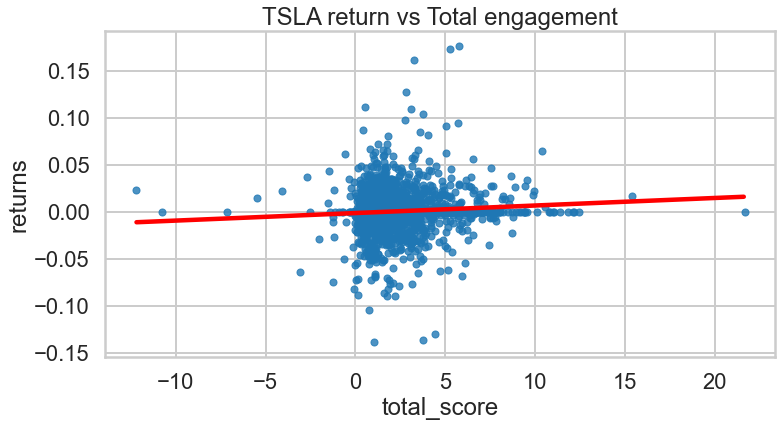

In [ ]:
#Visualize relationship between stock return and total score
sns.regplot(x='total_score', y="returns", data=Tesla_visual_group, ci=None, x_jitter=.05, scatter_kws={"s": 50},line_kws={'color':'red'})
plt.title("TSLA return vs Total engagement")
plt.show()

In [ ]:
#Filter data for positive tweets only
Tesla_pos = Tesla_visual[Tesla_visual['score'] == 'Positive']
Tesla_pos.head()

,post_date,score,total_score,returns,close_value
0,2015-01-01,Positive,3.0,0.0,222.41
1,2015-01-01,Positive,3.0,0.0,222.41
2,2015-01-01,Positive,5.0,0.0,222.41
3,2015-01-01,Positive,4.0,0.0,222.41
4,2015-01-01,Positive,4.0,0.0,222.41


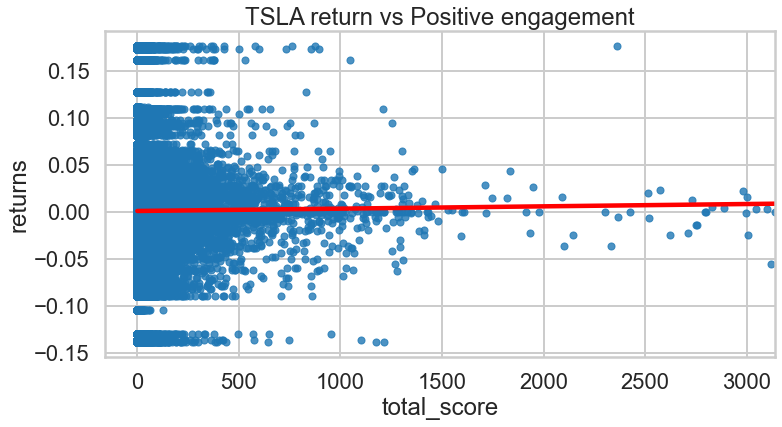

In [ ]:
#Visualize relationship between stock return and total score for positive tweets only
sns.regplot(x='total_score', y="returns", data=Tesla_pos, ci=None, x_jitter=.05, scatter_kws={"s": 50},line_kws={'color':'red'})
plt.title("TSLA return vs Positive engagement")
plt.show()

In [ ]:
#Filter data for negative tweets only
Tesla_neg = Tesla_visual[Tesla_visual['score'] == 'Negative']
Tesla_neg.head()

,post_date,score,total_score,returns,close_value
8,2015-01-01,Negative,-0.0,0.0,222.41
21,2015-01-01,Negative,-0.0,0.0,222.41
29,2015-01-01,Negative,-0.0,0.0,222.41
35,2015-01-01,Negative,-0.0,0.0,222.41
36,2015-01-01,Negative,-0.0,0.0,222.41


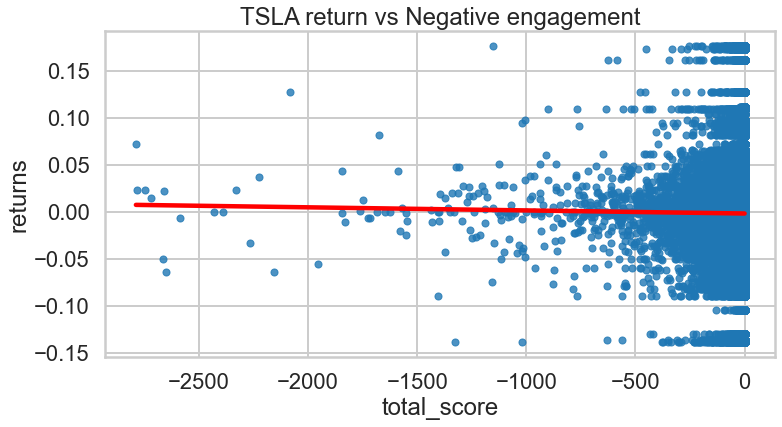

In [ ]:
#Visualize relationship between stock return and total score for negative tweets only
sns.regplot(x='total_score', y="returns", data=Tesla_neg, ci=None, x_jitter=.05, scatter_kws={"s": 50},line_kws={'color':'red'})
plt.title("TSLA return vs Negative engagement")
plt.show()

In [ ]:
Total_pos_tweets = Tesla_pos.groupby('post_date').mean('total_score')
Total_pos_tweets.head()

,total_score,returns,close_value
post_date,,,
2015-01-01,3.769231,0.000000,222.41
2015-01-02,1.776471,-0.013938,219.31
2015-01-03,3.173913,0.000000,219.31
2015-01-04,2.028571,0.000000,219.31
2015-01-05,1.136364,-0.042041,210.09


In [ ]:
Total_neg_tweets = Tesla_neg.groupby('post_date').mean('total_score')
Total_neg_tweets.head()

,total_score,returns,close_value
post_date,,,
2015-01-01,-3.000000,0.000000,222.41
2015-01-02,-1.838710,-0.013938,219.31
2015-01-03,-3.111111,0.000000,219.31
2015-01-04,-0.727273,0.000000,219.31
2015-01-05,-2.133333,-0.042041,210.09


<ipython-input-17-c9a9cb638296>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tesla_returns['returns'] = Tesla_returns['returns'].apply(lambda returns: returns*50)


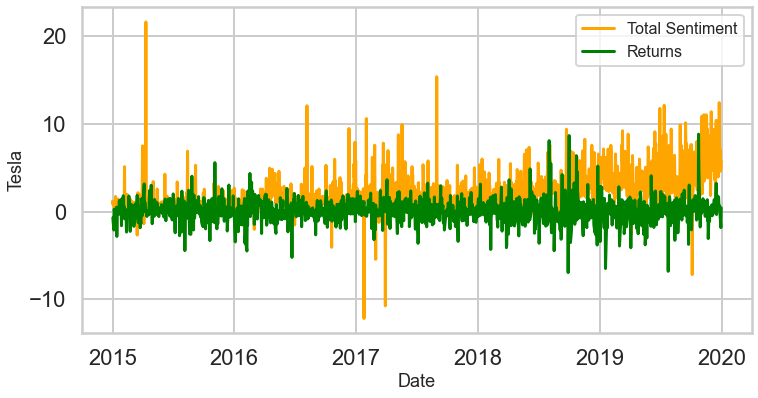

In [ ]:
#Visualize stock return and total score of sentiment per day.
Tesla_returns = Tesla_visual_group[Tesla_visual_group['returns'] != 0]
Tesla_returns['returns'] = Tesla_returns['returns'].apply(lambda returns: returns*50)
plt.xlabel("Date" , fontsize = 18)
plt.ylabel("Tesla", fontsize = 18)

sns.lineplot(
data = Tesla_posneg,
        x = 'post_date',
        y = 'total_score', 
        color = 'orange'
    )
sns.lineplot(
data = Tesla_returns,
        x = 'post_date',
        y = 'returns', 
        color = 'green'
    )
#"Positive Sentiment", "Negative Sentiment",
plt.legend(labels=["Total Sentiment", "Returns"],fontsize = 16)